# Praca domowa 1
W pierwszej pracy domowej, przyjrzymy się omawianym przeze mnie danym. Dokonamy ich wstępnej analizy, by zobaczyć na czym stoimy, oraz zadamy kilka pytań badawczych z odpowiedzią.

### Baza LIDC-IDRI
Pierw na celownik weźmy bazę, LIDC-IDRI, która składa się ze zdjęć tomografi komputerowej płuc ludzkich, zapisanych w formie DICOM.  
Każde z zdjęć posiada odpowiadające mu przypisany ręcznie przez radiologa label, który mieści się w trzech klasach, a mianowicie: "nodule > or =3 mm," "nodule <3 mm," and "non-nodule > or =3 mm", co czyni dla naszej potencjalnej sieci neuronowej/machine learningowej zadanie klasyfikacji wieloklasowej.

In [23]:
#importy
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
import glob

In [14]:
#Ponieważ dane pobrały się w dość nieprzystępną strukturę, uporządkuje je najpierw
PATH = "C:/Users/aaf6/LIDC-IDRI/manifest-1646859570080/LIDC-IDRI"

CT_scans_dicom_array = []
for file in glob.glob(PATH + '/**/*.dcm', recursive=True):
    CT_scans_dicom_array.append(dcmread(file))

In [15]:
#ile danych mamy?
len(CT_scans_dicom_array)

1873

In [123]:
#funkcje pomocnicze do plotowania
def plot_figures(indexes,data):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in indexes:
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, indexes.index(i)+1)
        plt.imshow(data[i].pixel_array,cmap=plt.cm.gray)
    plt.show()

In [33]:
#atrybuty dla pliku DICOM
dir(CT_scans_dicom_array[4])

['AccessionNumber',
 'AcquisitionDate',
 'AcquisitionDateTime',
 'AcquisitionTime',
 'AdmittingDate',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ContentCreatorName',
 'ContentDate',
 'ContentTime',
 'ContrastBolusAgent',
 'ConvolutionKernel',
 'CurveDate',
 'DataCollectionDiameter',
 'DeidentificationMethod',
 'DistanceSourceToDetector',
 'DistanceSourceToPatient',
 'Exposure',
 'ExposureTime',
 'FillerOrderNumberImagingServiceRequest',
 'FilterType',
 'FocalSpots',
 'FrameOfReferenceUID',
 'GantryDetectorTilt',
 'GeneratorPower',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'InstanceNumber',
 'KVP',
 'LastMenstrualDate',
 'LongitudinalTemporalInformationModified',
 'Manufacturer',
 'ManufacturerModelName',
 'Modality',
 'OverlayDate',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientIdentityRemoved',
 'PatientName',
 'PatientPosition',
 'PatientSex',
 'PerformedProcedureStepStartDate',
 'PersonName',
 'PhotometricIn

Ponieważ, personalnie, jest to pierwsze zetknięcie z plikami DICOM, zobaczmy jakie dane, poza samym zdjęciem, zawiera plik.

In [116]:
CT_scans_dicom_array[4]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.144082670553276891543830686836
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.14408

Co rzuca się w oczy? Jak widzimy sporo danych nie posiada doń żadnych opisów o ich charakterze ani żadnych uwag, należało by je sprawdzić. Część z danych, szczególnie danych wrażliwych bądź personalnych, została usunięta z systemu, jednakże czy na pewno każda zeń? W informacjach istnieją dane o podmiocie dostarczającym dane, może przydałoby się sprawdzić ilu dostarczycieli było w ogólności i ich dystrybucje.  
Ale zacznijmy od zerknięcia na przykładowe obrazy topografi komputerowej.

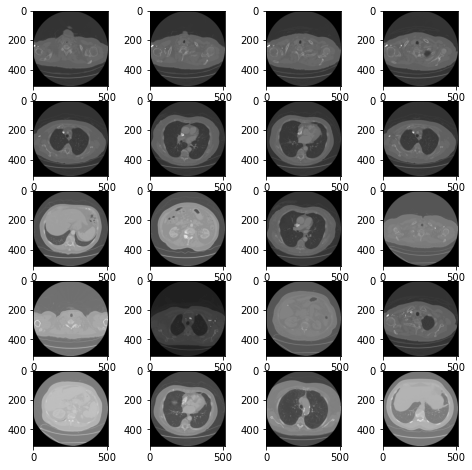

In [124]:
plot_figures([1,4,6,8,23,55,66,22,90,124,52,556,145,435,775,12,754,67,956,344],CT_scans_dicom_array)

Zacznijmy więc stawiać sobie pytania badawcze i udzielmy odpowiedzi nań.

Zobaczmy najpierw ilu producentów ('label Manufacturer') było ogólnie w naszej bazie oraz sprawdźmy ich rozkład liczbowy by zobaczyć skąd napływają nasze dane.

In [51]:
Manufacturers = []
for file in CT_scans_dicom_array:
    Manufacturers.append(file.Manufacturer)
a = set(Manufacturers)
print(list(a))
#mamy tylko dwóch dostawców
(sum(list(map(lambda x:1 if x == 'Philips Medical Systems' else 0,Manufacturers))) ,sum(list(map(lambda x:0 if x == 'Philips Medical Systems' else 1,Manufacturers))))

['Philips Medical Systems', 'GE MEDICAL SYSTEMS']


(2, 1871)

Jak widzimy, mamy dwóch producentów, z czego praktycznie całość stanowi GE MEDICAL SYSTEMS. Informacja o pochodzeniu danych dużo może nam powiedzieć o potencjalnych biasach bądź błędach systematycznych.

Jako kolejny punkt postarajmy się zweryfikować postanowienia biorcy danych o usunięciu danych personalnych (tudzież imienia) tam gdzie zostało to zarzeczone.  
Parametr "PatientIdentityRemoved" przechowuje stringa o wartościach "YES" lub "NO" odpowiadające czy imie pacjęta zostało usunięte. Następnie sprawdźmy to, porównując czy wartości w polach "PersonName" oraz "PatientName" rzeczywiście są puste.

In [61]:
name_not_deleted =0
names_leaked = []
for file in CT_scans_dicom_array:
        if file.PatientIdentityRemoved == 'YES' and file.PatientName != '' and file.PersonName != 'Removed by CTP':
            name_not_deleted += 1
            if file.PatientName != ' ':
                names_leaked.append(file.PatientName)
            if file.PersonName != ' ':
                names_leaked.append(file.PersonName)

In [64]:
name_not_deleted

0

Jak widzimy, administrator danych pacjentów zadbał o ich bezpieczeństwo i tam gdzie zastrzegł sobie ich usunięcie, rzeczywiście to zrobił!  
Jednakże, czy każde imię pacjenta zostało zastrzeżone na  usunięcie?

In [69]:
name_in_base =0
names = []
for file in CT_scans_dicom_array:
        if file.PatientIdentityRemoved == 'NO':
            name_in_base += 1
            names.append(file.PatientName)

In [70]:
name_in_base

0

Każde imię zostało usunięte, a więc niczego się nie dowiemy.

In [136]:
#niestety, ale informacja o płciach pacjentów została usunięta. Jednakże warto o tym napomnieć
sexes = []
for file in CT_scans_dicom_array:
    sexes.append(file.PatientSex)

In [137]:
set(sexes)

{''}

In [105]:
#Kolejna mało satysfakcjonująca informacja, wszystkie badania "Study time" mają tę samą wartość (jej brak), zatem nie są zbyt interesujące
#Pomimo to nadal je tu wypisuje jako pewną informację
times = []
for file in CT_scans_dicom_array:
    times.append(file.StudyTime)

In [104]:
set(times)

{''}

In [108]:
dates = []
for file in CT_scans_dicom_array:
    dates.append(file.StudyDate)

In [109]:
set(dates)

{'20000101'}

Tutaj mogliśmy wykryć pierwszy brak spójności w danych bądź zaniedbania szpitala.  
Wszystkie daty mają dokładnie tą samą datę 01/01/2000, co jest dość nieprawdopodobne, iż 1873 zdjęcia zostały sklafyfikowane jednego dnia przez garstkę specjalistów.

Po dokładniejszym przyjrzeniu się danym, wyciągam hipotezę, iż dane zostały zaniedbane lub bardzo leniwie wpisane.  
Mianowicie, każda dana reprezentująca datę wydaje się mieć tą samą wartość, mianowicie '20000101', co jest niemożliwe, iż wystąpiło w realu. Zatem dokonajmy oficialnego tego sprawdzenia.

In [110]:
dates_the_same = 0
for file in CT_scans_dicom_array:
    if file.AcquisitionDate == '20000101' and file.StudyDate =='20000101'and file.SeriesDate =='20000101'and file.ContentDate =='20000101'and file.OverlayDate=='20000101' and file.CurveDate=='20000101' and file.LastMenstrualDate=='20000101':
        dates_the_same += 1

In [111]:
dates_the_same

1873

Hipoteza została potwierdzona i rzeczywiście wszystkie pola reprezentujące datę są dokładnie takie same.

Na sam koniec, by nie zostać kompletnie zawiedzionym wynikami, wypiszmy wszystkie przypisane labele i sprawdźmy ich rozkład.

<BarContainer object of 2 artists>

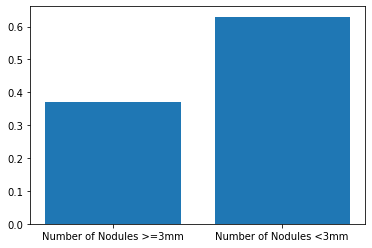

In [117]:
plt.bar(['Number of Nodules >=3mm','Number of Nodules <3mm'],[0.37,0.63])

Na koniec wypiszmy przypisane przez specjalistów labeli naszych danych, które oznaczają ilość zaobserwowanych guzów płuc odpowiednio o promieniach mniejszych bądź równych 3mm i o promieniach mniejszych bądź równych 3mm.  

## Wnioski

## Baza SIIM-ACR Pneumothorax Segmentation
Druga z baz zajmujse się problemem segmentacji, również na zdjęciach płuc, w celu znaleznienia nań odmy opucnej oraz zaznaczenia jej na obrazku. Poza czystą segmaentacją, zbiór danych zawiera również labele klasyfikujące binarnie, jednakże skupimy się na obrazach z pozytywnymi labelami.

In [118]:
PATH = "C:/Users/aaf6/siim-acr-pneumothorax-segmentation/stage_2_images"

SIMM_ACR_dicom_array = []
for file in glob.glob(PATH + '/**/*.dcm', recursive=True):
    SIMM_ACR_dicom_array.append(dcmread(file))

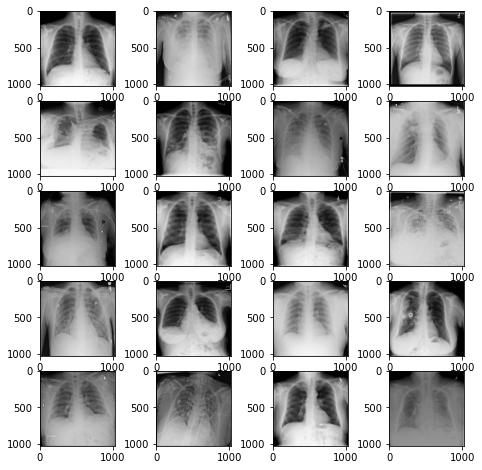

In [125]:
#zerknijmy na zdjęcia
plot_figures([1,4,6,8,23,55,66,22,90,124,52,556,145,435,775,12,754,67,956,344],SIMM_ACR_dicom_array)

In [219]:
#funkcje podane z bazą danych do maskowania
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [127]:
#zobaczmy atrybuty naszych plików dicom
dir(SIMM_ACR_dicom_array[4])
#nie są zawarte te same dane względem poprzednich obrazów dicom

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition',
 '__array__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__ne

Spróbujmy dokonać powtórzeń poprzednich rozważań jak na drugiej bazie danych, być może tym razem dane będą bardziej interesujące i nie będą występować takie braki jak poprzednio.

Pomimo, iż dane personalne pacjentów teoretycznie nie zostały usunięte (nie zostały wskazane na zostanie usuniętymi), to dokonajmy sprawdzenia 'niepustości' imion pacjentów. 

In [130]:
name_in_base = 0
names = []
for file in SIMM_ACR_dicom_array:
        name_in_base += 1
        names.append(file.PatientName)

In [131]:
set(names)

{''}

Imiona nie zostały podane.  
O większej nadzieji wiąże fakt potencjalnych informacji o płci pacjentów oraz o ich wieku.

In [142]:
sexes = []
for file in SIMM_ACR_dicom_array:
    sexes.append(file.PatientSex)

In [135]:
#dane są, zatem można np. wykonać wykres słupkowy
set(sexes)

{'F', 'M'}

In [145]:
from collections import Counter
print(Counter(sexes).keys())
print(Counter(sexes).values())

dict_keys(['F', 'M'])
dict_values([1452, 1753])


<BarContainer object of 2 artists>

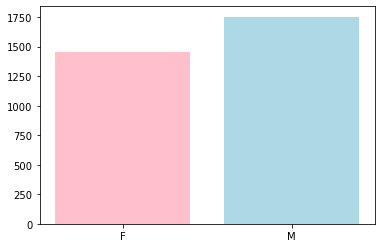

In [149]:
plt.bar(['F', 'M'],[1452, 1753],color=['pink','lightblue'])

Widzimy, iż mężczyźni stanowią, nieznacznie, większą grupę pacjentów u których wykryto odmę płucną.

Przechodząc dalej zbadajmy jak prezentują się dane dotyczące wieku pacjentów.

In [170]:
ages = []
for file in SIMM_ACR_dicom_array:
    ages.append(file.PatientAge)
print(Counter(ages).keys())
print(Counter(ages).values())

dict_keys(['64', '47', '62', '45', '38', '63', '24', '22', '33', '44', '46', '49', '2', '39', '52', '41', '26', '67', '66', '30', '48', '35', '61', '51', '74', '37', '70', '36', '56', '7', '81', '53', '31', '60', '13', '20', '54', '29', '43', '71', '55', '21', '23', '27', '59', '75', '69', '80', '58', '15', '4', '32', '50', '65', '42', '9', '68', '8', '34', '25', '78', '18', '57', '40', '10', '19', '6', '14', '82', '3', '16', '17', '28', '89', '73', '77', '72', '87', '76', '11', '83', '79', '12', '85', '152', '86', '5', '84'])
dict_values([75, 64, 56, 73, 30, 76, 50, 43, 45, 59, 65, 63, 1, 52, 77, 55, 38, 41, 71, 59, 80, 57, 46, 90, 17, 30, 29, 28, 86, 5, 15, 60, 52, 86, 14, 27, 74, 43, 64, 26, 63, 30, 58, 35, 69, 13, 40, 9, 89, 25, 6, 49, 80, 55, 31, 10, 42, 4, 44, 22, 9, 30, 86, 42, 7, 26, 3, 13, 5, 3, 15, 17, 37, 1, 28, 9, 15, 4, 14, 14, 8, 5, 7, 4, 1, 1, 4, 1])


In [161]:
L = [ (list(Counter(ages).keys())[i],i) for i in range(len(list(Counter(ages).keys()))) ]
L.sort()
sorted_l,permutation = zip(*L)

In [178]:
c = [ list(Counter(ages).values())[i] for i in permutation]

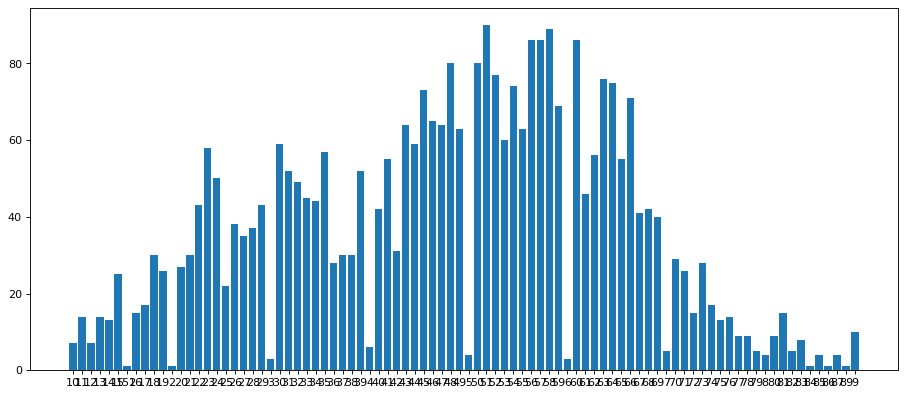

In [184]:
from matplotlib.pyplot import figure

figure(figsize=(14, 6), dpi=80)
plt.bar(sorted_l,c)
plt.show()

In [186]:
#osobno dla kobiet i dla mężczyzn?
female = []
male = []
for file in SIMM_ACR_dicom_array:
    if file.PatientSex == 'M':
        male.append(file)
    else:
        female.append(file)
ages_female = []
for file in female:
    ages_female.append(file.PatientAge)
ages_male = []
for file in male:
    ages_male.append(file.PatientAge)

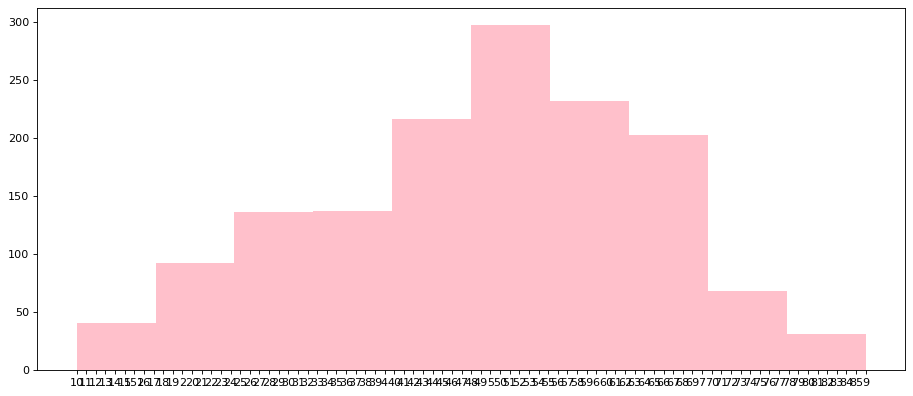

In [197]:
figure(figsize=(14, 6), dpi=80)
plt.hist(sorted(ages_female),color = 'pink')
plt.show()

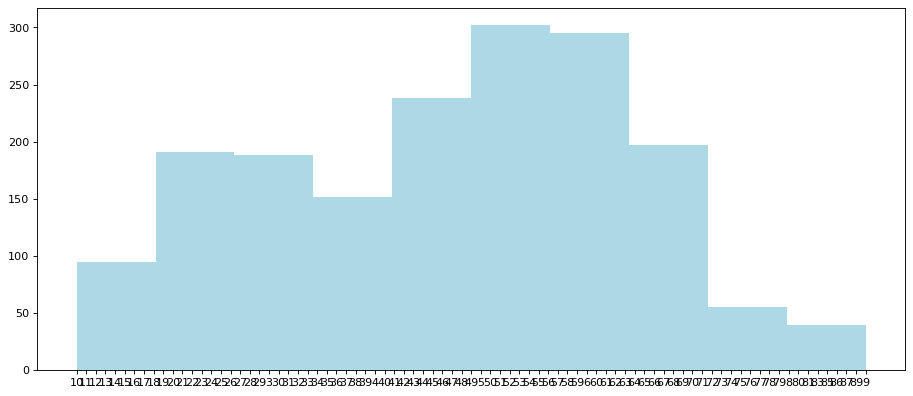

In [202]:
figure(figsize=(14, 6), dpi=80)
plt.hist(sorted(ages_male),color = 'lightblue',label = sorted(set(ages_male)))
plt.show()

Pomimo, iż mężczyzn było więcej w bazie danych, ich dstrybucja należała do bardziej przechylonej w stronę prawą względem wieku.

Posiadając już pewne informacje o danych o wieku, zobaczmy teraz jak prezentują się dane dotyczące czasu badania, dokonajmy ich od razu osobno dla kobiet i mężczyzn. 
Na koniec dokonajmy sprawdzenia rozkładu czasów badań nad pacjentami, z dokładnością do ich płci, czy będą takie same?

In [203]:
times_male = []
times_female = []
for file in female:
    times_female.append(file.StudyTime)
for file in male:
    times_male.append(file.StudyTime)

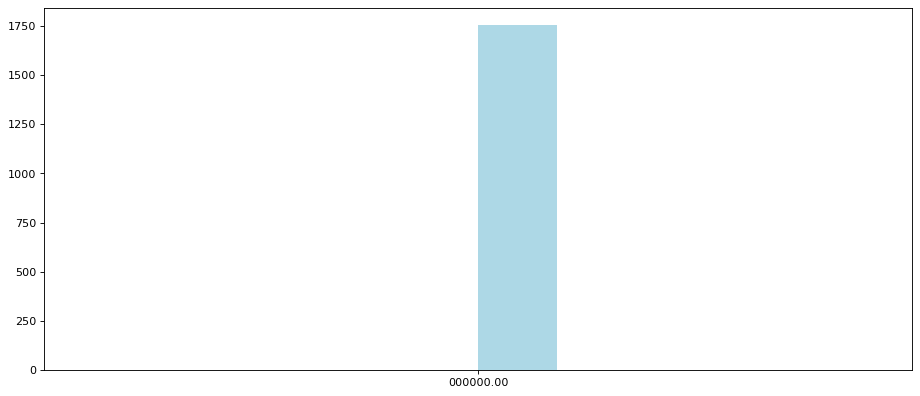

In [204]:
figure(figsize=(14, 6), dpi=80)
plt.hist(sorted(times_male),color = 'lightblue')
plt.show()

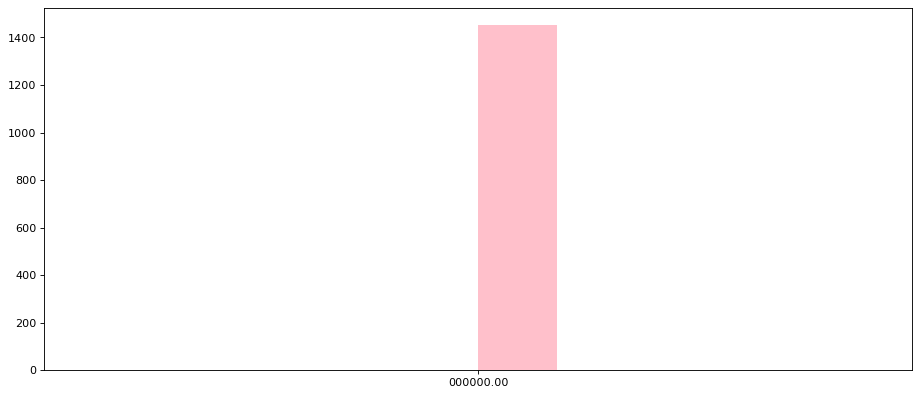

In [206]:
figure(figsize=(14, 6), dpi=80)
plt.hist(sorted(times_female),color = 'pink')
plt.show()

I takim sposobem odkryliśmy znowu brak pewnych danych, gdyż z całą pewnością klasyfikujący specjaliści nie byli w stanie dokonać tak szybkiej analizy.

In [232]:
def show_image_mask(img_data, th):
    img_data = img_data/255.
    f = plt.figure()
    f.set_figwidth(15)

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    mask = data > th

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    plt.hist(img_data[mask], bins = 256)

    plt.show()